In [1]:
import numpy as np
import matplotlib.pyplot as plt
from rlxutils import subplots
import pandas as pd
import sys
sys.path.append("..")
import torch
from torch import nn

from lib import data
from lib import sar
from lib import io

from torch import nn  
from loguru import logger
from lib.datamodules.components import scatterdataset
from lib.datamodules import scatterdatamodule
from lib.models import scattermodel
from omegaconf import OmegaConf
import hydra
import pprint
from progressbar import progressbar as pbar
from importlib import reload
reload(scatterdataset)
reload(scattermodel)

<module 'lib.models.scattermodel' from '/home/ubuntu/sar-recovery/notebooks/../lib/models/scattermodel.py'>


**Quad-Pol SAR Data Reconstruction from Dual-Pol SAR Mode Based on a Multiscale Feature Aggregation Network**, https://www.mdpi.com/2072-4292/15/17/4182

$$
S=
\begin{bmatrix}
S_{HH} & S_{HV} \\
S_{VH} & S_{VV} \\
\end{bmatrix}
$$

$$
C=
\begin{bmatrix}
\langle |S_{HH}|^2 \rangle & \sqrt{2} \langle S_{HH}S^{*}_{HV} \rangle &  \langle S_{HH}S^{*}_{VV}\rangle \\
\sqrt{2} \langle S_{HV}S^{*}_{HH} \rangle &  2 \langle |S_{HV}|^2 \rangle  & \sqrt{2} \langle S_{HV}S^{*}_{VV} \rangle \\
\langle S_{VV}S^{*}_{HH} \rangle & \sqrt{2} \langle S_{VV}S^{*}_{HV}\rangle & \langle |S_{VV}|^2 \rangle
\end{bmatrix}
$$

## load hydra conf

In [2]:
conf = OmegaConf.load("../configs/scatter2coherence.yaml")
pprint.pp(OmegaConf.to_container(conf))

{'dataloader': {'_target_': 'lib.datamodules.scatterdatamodule.ScatterCoherencePatchesDataModule',
                'base_path': '/home/rlx/data/sar-recovery',
                'date_train': 20100520,
                'date_test': 20120720,
                'date_val': 20120720,
                'scatter_elems': ['Shh', 'Shv'],
                'coherence_elems': ['Svv2'],
                'patch_size': 60,
                'avg_window_size': 5,
                'splitmask_fn_src': 'lambda h, w: '
                                    'data.cv_splitpixels_spatial(h, w, '
                                    'pixels_train = 280, pixels_test = 60, '
                                    'pixels_val = 60, angle = np.pi/4)'},
 'model': {'_target_': 'lib.models.scattermodel.Scatter2CoherenceM1',
           'in_channels': 2}}


## instantiate dataloader

In [3]:
dl = hydra.utils.instantiate(conf.dataloader)

2024-05-05 13:00:45.317 | INFO     | lib.datamodules.components.scatterdataset:__init__:44 - loading scatter matrix
2024-05-05 13:00:45.464 | INFO     | lib.datamodules.components.scatterdataset:__init__:47 - computing coherence matrix
2024-05-05 13:00:49.112 | INFO     | lib.datamodules.components.scatterdataset:__init__:58 - scatter   matrix shape is (4402, 1602, 2, 2), retrieving elems [('Shh', [0, 0]), ('Shv', [0, 1])]
2024-05-05 13:00:49.112 | INFO     | lib.datamodules.components.scatterdataset:__init__:59 - coherence matrix shape is (4402, 1602, 3, 3), retrieving elems [('Svv2', (2, 2))]
2024-05-05 13:00:49.115 | INFO     | lib.datamodules.components.scatterdataset:__init__:44 - loading scatter matrix
2024-05-05 13:00:49.263 | INFO     | lib.datamodules.components.scatterdataset:__init__:47 - computing coherence matrix
2024-05-05 13:00:52.902 | INFO     | lib.datamodules.components.scatterdataset:__init__:58 - scatter   matrix shape is (4402, 1602, 2, 2), retrieving elems [('Shh

In [4]:
traindl = dl.train_dataloader()
testdl  = dl.test_dataloader()
valdl   = dl.val_dataloader()

In [5]:
len(traindl), len(testdl), len(valdl)

(84, 18, 18)

## instantiate model

In [6]:
m = hydra.utils.instantiate(conf.model)
optimizer = torch.optim.Adam(m.parameters(), lr=5e-3)
nparams = sum([len(p.flatten()) for p in m.parameters() if p.requires_grad])
print (f"number of model parameters {nparams}")

number of model parameters 42528


In [8]:
x = traindl.dataset[0]
x.keys()

dict_keys(['scatter_patch', 'coherence_patch', 'patch_coords', 'avg_coherence_patch'])

In [9]:
x['scatter_patch'].shape, x['avg_coherence_patch'].shape

((2, 60, 60), (1, 12, 12))

In [135]:
reload(scattermodel)
m = scattermodel.Scatter2CoherenceM4(in_channels=2, freeze_last_layer=True)

nparams = sum([len(p.flatten()) for p in m.parameters() if p.requires_grad])
print (f"number of model parameters {nparams}")

2024-05-06 03:21:36.376 | INFO     | lib.models.scattermodel:__init__:282 - freezing last layer


number of model parameters 9294


In [136]:
m.get_output_shape((60,60))

torch.Size([12, 12])

In [137]:
m.layers

Sequential(
  (0): Conv2d(2, 10, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ComplexActivation()
  (2): ComplexBatchNorm2d()
  (3): Conv2d(10, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (4): ComplexActivation()
  (5): ComplexBatchNorm2d()
  (6): Conv2d(64, 5, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (7): ComplexActivation()
  (8): ComplexBatchNorm2d()
  (9): Conv2d(5, 1, kernel_size=(5, 5), stride=(5, 5))
)

## train loop

In [138]:
#m = hydra.utils.instantiate(conf.model)
optimizer = torch.optim.Adam(m.parameters(), lr=5e-5)

In [139]:
dtr = dl.train_dataloader()
complex_rmse_loss_fn = lambda y_true, y_pred: torch.sqrt(torch.mean((y_pred-y_true)*(y_pred-y_true).conj()).real)
complex_mse_loss_fn = lambda y_true, y_pred: torch.mean((y_pred-y_true)*(y_pred-y_true).conj()).real
loss_fn = complex_rmse_loss_fn

In [ ]:
n_epochs = 10000

lossh = []
for epoch in range(n_epochs):
    loss_epoch = []
    for step, batch in enumerate(dtr):
        # extract data from batch
        x = batch['scatter_patch']
        t = batch['avg_coherence_patch'] / 20000

        # run model
        o = m(x)
        o_std = o.std()
        # compute losses (complex mse or rmse)
        loss = loss_fn(t, o)

        # backpropage and update
        loss.backward()
        optimizer.step()

        # cosmetics
        ogt0 = (o.real.detach().numpy()>0).mean()
        tgt0 = (t.real.detach().numpy()>0).mean()
        lossn = loss.detach().cpu().numpy()
        loss_epoch.append(lossn)
        lossh.append(lossn)
        psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in m.parameters()])    
        lossm = np.mean(lossh[-500:])
        print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} params {psummary:.7f} o>0 {ogt0:.3f} t>0 {tgt0:.3f} o.std {o_std:.5f}", end="\r")
        
    print(f"epoch {epoch:3}          loss {np.mean(loss_epoch):.4f}")


epoch   0          loss 49.37489 params 0.3157228 o>0 0.451 t>0 1.000 o.std 36.24656
epoch   1          loss 48.65889 params 0.3169432 o>0 0.458 t>0 1.000 o.std 32.83945
epoch   2          loss 36.50214 params 0.3180383 o>0 0.542 t>0 1.000 o.std 28.51838
epoch   3          loss 31.66279 params 0.3193569 o>0 0.493 t>0 1.000 o.std 26.52457
epoch   4          loss 32.45696 params 0.3206255 o>0 0.451 t>0 1.000 o.std 33.63720
epoch   5          loss 26.49954 params 0.3216437 o>0 0.451 t>0 1.000 o.std 25.41224
epoch   6          loss 22.54436 params 0.3228786 o>0 0.556 t>0 1.000 o.std 21.37806
epoch   7          loss 23.78460 params 0.3247714 o>0 0.507 t>0 1.000 o.std 20.07134
epoch   8          loss 19.91842 params 0.3264746 o>0 0.521 t>0 1.000 o.std 17.24759
epoch   9          loss 19.91839 params 0.3284699 o>0 0.569 t>0 1.000 o.std 21.67478
epoch  10          loss 18.82821 params 0.3298483 o>0 0.507 t>0 1.000 o.std 16.16346
epoch  11          loss 18.19160 params 0.3317574 o>0 0.396 t>0 1

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



epoch 1052          loss 7.49780 params 3.6879063 o>0 1.000 t>0 1.000 o.std 1.96665
epoch 1053          loss 7.42213 params 3.6910608 o>0 1.000 t>0 1.000 o.std 2.52815
epoch 1054          loss 7.34771 params 3.6941445 o>0 1.000 t>0 1.000 o.std 2.04050
epoch 1055          loss 7.24058 params 3.6973863 o>0 1.000 t>0 1.000 o.std 3.13780
epoch 1056          loss 6.94974 params 3.7008045 o>0 1.000 t>0 1.000 o.std 2.13740
epoch 1057          loss 6.90463 params 3.7041724 o>0 0.757 t>0 1.000 o.std 1.56393
epoch 1058          loss 7.17168 params 3.7074986 o>0 0.493 t>0 1.000 o.std 1.38250
epoch 1059          loss 7.50573 params 3.7109921 o>0 0.333 t>0 1.000 o.std 1.04742
epoch 1060          loss 7.86096 params 3.7145040 o>0 0.069 t>0 1.000 o.std 3.52413
epoch 1061          loss 7.76175 params 3.7178705 o>0 0.097 t>0 1.000 o.std 1.15810
epoch 1062          loss 7.54434 params 3.7210758 o>0 0.215 t>0 1.000 o.std 1.89390
epoch 1063          loss 7.57492 params 3.7241340 o>0 0.139 t>0 1.000 o.std 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



epoch 1962          loss 6.88438 params 6.8516603 o>0 0.889 t>0 1.000 o.std 1.39080
epoch 1963          loss 6.64559 params 6.8547373 o>0 0.632 t>0 1.000 o.std 3.75935
epoch 1964          loss 6.77892 params 6.8581495 o>0 0.493 t>0 1.000 o.std 1.62321
epoch 1965          loss 7.09426 params 6.8618155 o>0 0.312 t>0 1.000 o.std 1.48330
epoch 1966          loss 7.52748 params 6.8654208 o>0 0.243 t>0 1.000 o.std 2.15171
epoch 1967          loss 7.77795 params 6.8688998 o>0 0.174 t>0 1.000 o.std 3.23719
epoch 1968          loss 7.83129 params 6.8722372 o>0 0.257 t>0 1.000 o.std 1.79338
epoch 1969          loss 7.68678 params 6.8754687 o>0 0.250 t>0 1.000 o.std 2.41619
epoch 1970          loss 7.28105 params 6.8785868 o>0 0.375 t>0 1.000 o.std 1.12361
epoch 1971          loss 7.00022 params 6.8817267 o>0 0.514 t>0 1.000 o.std 1.38306
epoch 1972          loss 6.77395 params 6.8852172 o>0 0.750 t>0 1.000 o.std 1.59183
epoch 1973          loss 6.67085 params 6.8889823 o>0 0.896 t>0 1.000 o.std 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



epoch 2104          loss 6.68601 params 7.3353882 o>0 0.701 t>0 1.000 o.std 2.01351
epoch 2105          loss 6.88006 params 7.3388243 o>0 0.458 t>0 1.000 o.std 1.91445
epoch 2106          loss 7.28595 params 7.3424225 o>0 0.222 t>0 1.000 o.std 2.69370
epoch 2107          loss 7.53424 params 7.3460121 o>0 0.250 t>0 1.000 o.std 1.44725
epoch 2108          loss 7.70409 params 7.3495169 o>0 0.146 t>0 1.000 o.std 1.36086
epoch 2109          loss 7.77702 params 7.3529458 o>0 0.090 t>0 1.000 o.std 2.43990
epoch 2110          loss 7.55936 params 7.3562384 o>0 0.201 t>0 1.000 o.std 1.34714
epoch 2111          loss 7.39686 params 7.3593984 o>0 0.194 t>0 1.000 o.std 1.83836
epoch 2112          loss 7.06415 params 7.3625855 o>0 0.250 t>0 1.000 o.std 3.28993
epoch 2113          loss 6.72176 params 7.3664436 o>0 0.729 t>0 1.000 o.std 1.35370
epoch 2114          loss 6.79711 params 7.3702536 o>0 0.965 t>0 1.000 o.std 3.26061
epoch 2115          loss 7.05051 params 7.3739805 o>0 0.993 t>0 1.000 o.std 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



epoch 2523          loss 7.30094 params 8.7706108 o>0 0.986 t>0 1.000 o.std 1.24549
epoch 2524          loss 7.37170 params 8.7740650 o>0 1.000 t>0 1.000 o.std 1.49732
epoch 2525          loss 7.50385 params 8.7773685 o>0 1.000 t>0 1.000 o.std 1.81226
epoch 2526          loss 7.43895 params 8.7805395 o>0 1.000 t>0 1.000 o.std 2.06260
epoch 2527          loss 7.19946 params 8.7836962 o>0 1.000 t>0 1.000 o.std 1.28716
epoch 2528          loss 7.19129 params 8.7870989 o>0 0.993 t>0 1.000 o.std 2.20016
epoch 2529          loss 7.10476 params 8.7904348 o>0 0.979 t>0 1.000 o.std 1.46049
epoch 2530          loss 7.12335 params 8.7937202 o>0 0.910 t>0 1.000 o.std 1.57059
epoch 2531          loss 7.12037 params 8.7970095 o>0 0.826 t>0 1.000 o.std 1.18618
epoch 2532          loss 7.08535 params 8.8002453 o>0 0.444 t>0 1.000 o.std 1.79414
epoch 2533          loss 7.19321 params 8.8036623 o>0 0.174 t>0 1.000 o.std 3.16432
epoch 2534          loss 7.17490 params 8.8071699 o>0 0.139 t>0 1.000 o.std 

(5.0, 10.0)

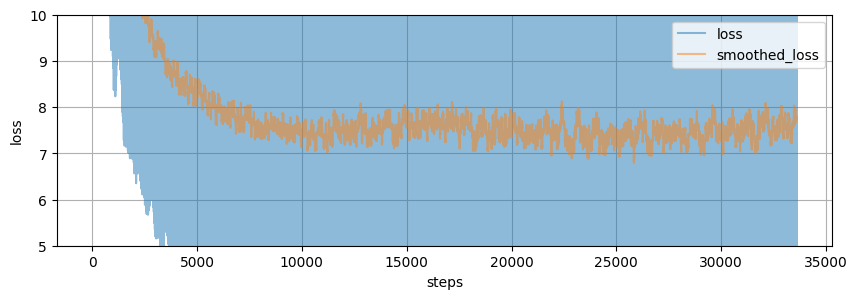

In [112]:
lossp = pd.DataFrame(lossh, columns=['loss'])
lossp['smoothed_loss'] = lossp.loss.rolling(500).mean()
lossp.plot(alpha=.5, figsize=(10,3))
plt.grid(); plt.xlabel("steps"); plt.ylabel("loss")
plt.ylim(5,10)


(1.0, 5.0)

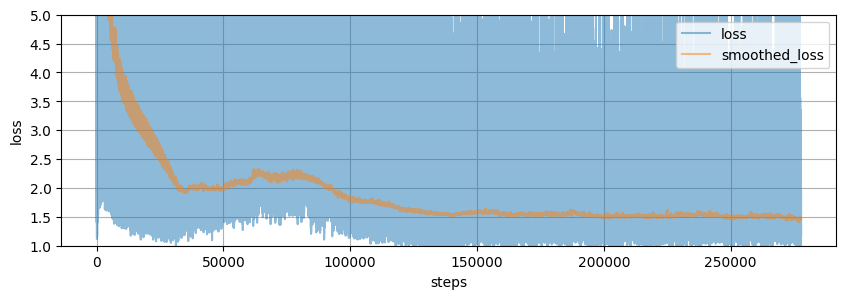

In [12]:
lossp = pd.DataFrame(lossh, columns=['loss'])
lossp['smoothed_loss'] = lossp.loss.rolling(500).mean()
lossp.plot(alpha=.5, figsize=(10,3))
plt.grid(); plt.xlabel("steps"); plt.ylabel("loss")
plt.ylim(1,5)


In [43]:
dataloader = dl.train_dataloader()


In [44]:
def get_predictions(dataloader):
    inputs, targets, predictions = [], [], []
    losses = []
    for batch in pbar(dataloader):
            x = batch['scatter_patch']
            t = batch['avg_coherence_patch'] / 20000
            o = m(x)
            losses.append(loss_fn(t,o))
            for i in range(len(x)):
                inputs.append(x[i])
                targets.append(t[i])
                predictions.append(o[i])
    return torch.stack(inputs), torch.stack(targets), torch.stack(predictions), torch.stack(losses)

In [45]:
tr_inputs, tr_targets, tr_predictions, tr_losses = get_predictions(dl.train_dataloader())
ts_inputs, ts_targets, ts_predictions, ts_losses = get_predictions(dl.test_dataloader())
val_inputs, val_targets, val_predictions, val_losses = get_predictions(dl.val_dataloader())

100% (84 of 84) |########################| Elapsed Time: 0:00:26 Time:  0:00:260002
100% (18 of 18) |########################| Elapsed Time: 0:00:07 Time:  0:00:070000
100% (18 of 18) |########################| Elapsed Time: 0:00:07 Time:  0:00:070000


In [46]:
tr_losses.mean(), ts_losses.mean(), val_losses.mean()

(tensor(1.2659, grad_fn=<MeanBackward0>),
 tensor(5.6187, grad_fn=<MeanBackward0>),
 tensor(5.5599, grad_fn=<MeanBackward0>))

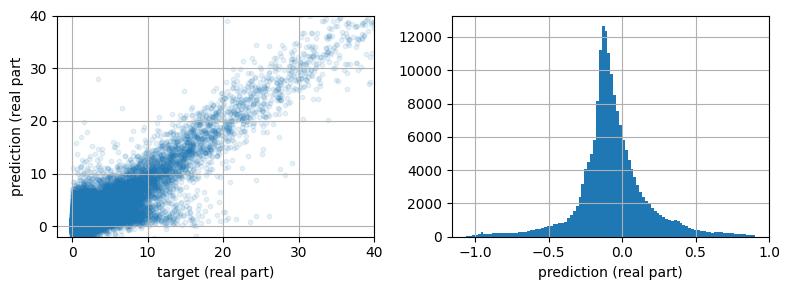

In [47]:
targets, predictions = tr_targets, tr_predictions
for ax,i in subplots(2, usizex=4):
    if i==0:
        _t = targets.detach().numpy().real.flatten()
        _o = predictions.detach().numpy().real.flatten()
        ta,tb = np.percentile(_t, [0,95])
        oa,ob = np.percentile(_o, [1,95])
        plt.scatter(_t, _o, s=10, alpha=.1);
        plt.xlim(-2,40)
        plt.ylim(-2,40)
        plt.grid();
        plt.xlabel("target (real part)")
        plt.ylabel("prediction (real part")
    if i==1:
        _o = predictions.detach().numpy().imag.flatten()
        a,b = np.percentile(_o, [1,99])
        _o = _o[(_o>a)&(_o<b)]
        plt.hist(_o, bins=100);
        plt.grid();
        plt.xlabel("prediction (real part)")